In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy
from scipy.ndimage import uniform_filter1d

In [2]:
df = pd.read_csv("../data/experiment_1_learning_curves.csv")
df.head()

,Step,Reward,Run,Configuration
0,1,0.764439,1,Greedy
1,2,3.396953,1,Greedy
2,3,2.188690,1,Greedy
3,4,1.057835,1,Greedy
4,5,2.354321,1,Greedy


In [3]:
grouped = (
    df.groupby(["Step", "Configuration"])["Reward"].agg(["mean", "std"]).reset_index()
)
grouped.rename(columns={"mean": "Mean", "std": "Std"}, inplace=True)
grouped

,Step,Configuration,Mean,Std
0,1,Epsilon Greedy: ε=0.1,-0.043915,1.494637
1,1,Greedy,0.038637,1.509874
2,2,Epsilon Greedy: ε=0.1,0.290669,1.436208
3,2,Greedy,0.243458,1.364307
4,3,Epsilon Greedy: ε=0.1,0.405608,1.357757
...,...,...,...,...
1995,998,Greedy,0.996345,1.203266
1996,999,Epsilon Greedy: ε=0.1,1.321322,1.353612
1997,999,Greedy,1.036407,1.152788
1998,1000,Epsilon Greedy: ε=0.1,1.420235,1.314955


In [5]:
def plot_with_smoothing_and_std(
    df: pd.DataFrame, smoothing_window: int = 50, num_runs: int = 500
) -> None:
    """Plot data with smoothing, mean, and standard deviation using Matplotlib.

    Args:
        df: Pandas DataFrame containing columns ["Step", "Reward", "Run", "Configuration"].
        smoothing_window: Size of the window for smoothing rewards and standard deviation.

    """
    # Alternatively, aggregate across "sem" instead of "std" and skip the Sem computation step below
    grouped = (
        df.groupby(["Step", "Configuration"])["Reward"]
        .agg(["mean", "std"])
        .reset_index()
    )

    grouped.rename(columns={"mean": "Mean", "std": "Std"}, inplace=True)

    plt.figure(figsize=(12, 6))
    configurations = grouped["Configuration"].unique()
    for config in configurations:
        subset = deepcopy(grouped[grouped["Configuration"] == config])
        subset["Sem"] = subset["Std"] / np.sqrt(1000)

        subset["Smoothed Mean"] = subset.groupby("Configuration")["Mean"].transform(
            lambda x: uniform_filter1d(x, size=smoothing_window, mode="nearest")
        )
        subset["Smoothed Sem"] = subset.groupby("Configuration")["Sem"].transform(
            lambda x: uniform_filter1d(x, size=smoothing_window, mode="nearest")
        )
        print(np.mean(subset['Smoothed Mean']), np.mean(subset['Smoothed Sem']))

        plt.plot(subset["Step"], subset["Smoothed Mean"], label=f"{config} (±1 SE)")
        plt.fill_between(
            subset["Step"],
            subset["Smoothed Mean"] - subset["Smoothed Sem"],
            subset["Smoothed Mean"] + subset["Smoothed Sem"],
            alpha=0.2,
        )
    plt.title("Average Reward Learning Curve with Smoothing and Standard Error")
    plt.xlabel("Steps")
    plt.ylabel("Average Reward")
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

1.329204103755996 0.040675792719906755
1.0356724952558383 0.03691297933921176


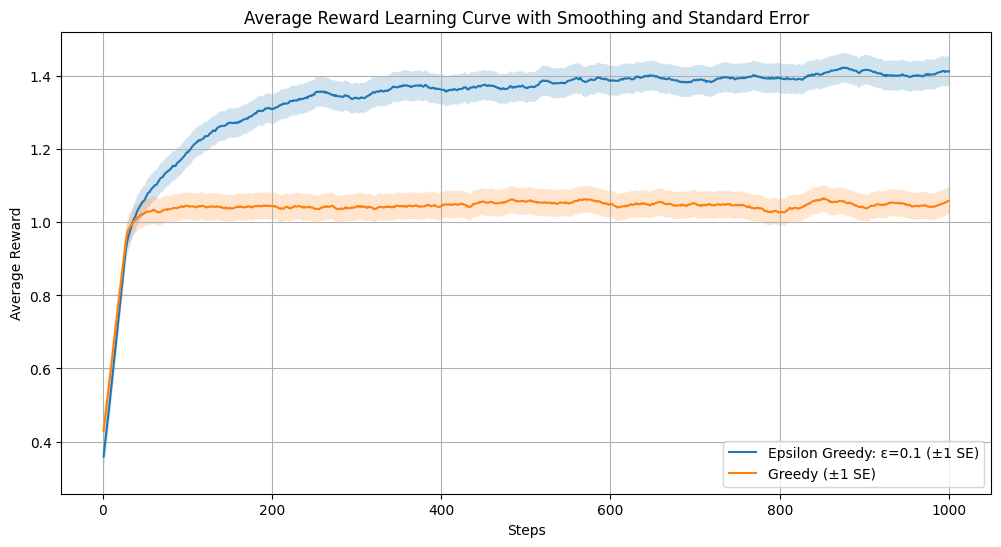

In [6]:
plot_with_smoothing_and_std(df, smoothing_window=50)